In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import gc

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.regularizers import l1, l2

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, Embedding, GlobalAveragePooling2D, Masking

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#from utils import get_model, find_closest, get_sequences, create_train_valid,  generate_output, guess_human

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
pd.set_option('max_colwidth', -1)

Using TensorFlow backend.


In [3]:
data_original = pd.read_csv('data_seq.csv', sep = ';')
print(data_original.shape)
data_original.head()

(48228, 12)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime
0,Lince™,G9UUP2GY,70.0,CRL EU,8330785.0,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142.0,51.0,91.0,2019-05-11
1,Chiqui,200L89QP,71.0,SLO - QLASH,8523346.0,Hogrider,SameClan,"skeletons,ice-spirit,the-log,ice-golem,cannon,musketeer,fireball,hog-rider",7.0,3.0,4.0,2019-05-11
2,Kaiju JN,LYU9C09J,56.0,Black EF / PG / CTP - Kaiju eSports,8523672.0,Golem,Friendly,"barbarian-barrel,ice-wizard,tornado,mega-minion,lumberjack,baby-dragon,lightning,golem",3.0,1.0,2.0,2019-05-11
3,x6 Necro,PL2YC0,9.0,Black EF / PGL / CTP - x6tence Black,8523753.0,3Musk,Friendly,"ice-golem,zap,goblin-gang,miner,battle-ram,minion-horde,elixir-collector,three-musketeers",1.0,1.0,0.0,2019-05-11
4,xPedro15,VLURPP9,70.0,CRL EU,8526335.0,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14.0,6.0,8.0,2019-05-11


### Data cleaning

In [4]:
data_original['date'] = pd.to_datetime(data_original['BattleTime']).dt.date

In [5]:
data_original.dropna(axis = 0, inplace = True)

In [6]:
ints = ['TeamId', 'DeckId', 'Games', 'Losses', 'Wins']
for col in ints:
    data_original[col] = data_original[col].astype(int)
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11
1,Chiqui,200L89QP,71,SLO - QLASH,8523346,Hogrider,SameClan,"skeletons,ice-spirit,the-log,ice-golem,cannon,musketeer,fireball,hog-rider",7,3,4,2019-05-11,2019-05-11
2,Kaiju JN,LYU9C09J,56,Black EF / PG / CTP - Kaiju eSports,8523672,Golem,Friendly,"barbarian-barrel,ice-wizard,tornado,mega-minion,lumberjack,baby-dragon,lightning,golem",3,1,2,2019-05-11,2019-05-11
3,x6 Necro,PL2YC0,9,Black EF / PGL / CTP - x6tence Black,8523753,3Musk,Friendly,"ice-golem,zap,goblin-gang,miner,battle-ram,minion-horde,elixir-collector,three-musketeers",1,1,0,2019-05-11,2019-05-11
4,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11


### Clean Cards Ids

In [7]:
#print(', '.join(sorted(data_original['CardKeysRaw'][0].split(','))))

In [8]:
data_original['CardKeysRawSorted'] = data_original['CardKeysRaw'].apply(lambda x: ', '.join(sorted(x.split(','))))
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"
1,Chiqui,200L89QP,71,SLO - QLASH,8523346,Hogrider,SameClan,"skeletons,ice-spirit,the-log,ice-golem,cannon,musketeer,fireball,hog-rider",7,3,4,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"
2,Kaiju JN,LYU9C09J,56,Black EF / PG / CTP - Kaiju eSports,8523672,Golem,Friendly,"barbarian-barrel,ice-wizard,tornado,mega-minion,lumberjack,baby-dragon,lightning,golem",3,1,2,2019-05-11,2019-05-11,"baby-dragon, barbarian-barrel, golem, ice-wizard, lightning, lumberjack, mega-minion, tornado"
3,x6 Necro,PL2YC0,9,Black EF / PGL / CTP - x6tence Black,8523753,3Musk,Friendly,"ice-golem,zap,goblin-gang,miner,battle-ram,minion-horde,elixir-collector,three-musketeers",1,1,0,2019-05-11,2019-05-11,"battle-ram, elixir-collector, goblin-gang, ice-golem, miner, minion-horde, three-musketeers, zap"
4,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"


In [9]:
Decks = pd.DataFrame({'deck':data_original['CardKeysRawSorted']})
print(Decks.shape)
Decks.head()
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

(48205, 1)
(12898, 2)


,deck,times,deck_id_int
3155,"balloon, barbarian-barrel, bats, giant-snowball, ice-golem, inferno-tower, miner, rascals",343,0
1403,"baby-dragon, barbarian-barrel, electro-wizard, furnace, guards, lightning, mega-minion, royal-giant",339,1
792,"baby-dragon, bandit, barbarian-barrel, electro-wizard, giant-snowball, pekka, poison, ram-rider",320,2
4938,"bandit, battle-ram, fireball, giant-snowball, ice-golem, minions, musketeer, prince",316,3
10052,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4


#### Delete redundant Decks 

In [10]:
data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRawSorted', right_on = 'deck')
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4
1,Chiqui,200L89QP,71,SLO - QLASH,8523346,Hogrider,SameClan,"skeletons,ice-spirit,the-log,ice-golem,cannon,musketeer,fireball,hog-rider",7,3,4,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4
2,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4


In [11]:
indexNames = data_original[(data_original.Games == 1) & (data_original.times == 1)].index
data_original.drop(axis = 0, index = indexNames, inplace = True)
data_original.drop(axis = 1, inplace = True, columns=['deck_id_int', 'times', 'deck'])
data_original = data_original.reset_index(drop = True)
data_original.shape

#We need to re'generate the decks ids

Decks = pd.DataFrame({'deck':data_original['CardKeysRawSorted']})
print(Decks.shape)
Decks.head()
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRawSorted', right_on = 'deck')
data_original.head(3)

(41782, 1)
(6475, 2)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4
1,Chiqui,200L89QP,71,SLO - QLASH,8523346,Hogrider,SameClan,"skeletons,ice-spirit,the-log,ice-golem,cannon,musketeer,fireball,hog-rider",7,3,4,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4
2,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4


### Data preparation

In [12]:
player_unique = data_original.Tag.unique()
teams_unique = data_original.TeamId.unique()
deck_unique = data_original.deck_id_int.unique()
archetype_unique = data_original.Archetype.unique()
usage_unique = data_original.Usage.unique()

print (f'We have {len(player_unique)} unique Players {len(teams_unique)} unique Teams'+\
       f' {len(deck_unique) } unique Decks {len(archetype_unique)} unique Archetypes and {len(usage_unique)} types of usages')

We have 430 unique Players 47 unique Teams 6475 unique Decks 23 unique Archetypes and 4 types of usages


In [13]:
players_map = {i:val for i,val in enumerate(player_unique)}
players_map_inv = {val:i for i,val in enumerate(player_unique)}

teams_map = {i:val for i,val in enumerate(teams_unique)}
teams_map_inv = {val:i for i,val in enumerate(teams_unique)}

decks_map = {i:val for i,val in enumerate(deck_unique)}
decks_map_inv = {val:i for i,val in enumerate(deck_unique)}

archetypes_map = {i:val for i,val in enumerate(archetype_unique)}
archetypes_map_inv = {val:i for i,val in enumerate(archetype_unique)}

usages_map = {i:val for i,val in enumerate(usage_unique)}
usages_map_inv = {val:i for i,val in enumerate(usage_unique)}

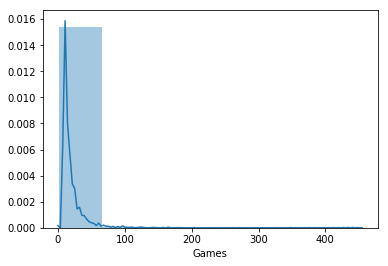

In [14]:
sns.distplot(data_original['Games'], bins = 7)

## Mapping Cards

In [15]:
data_original['CardKeysRaw'] = data_original['CardKeysRaw'].str.replace('-', '')
data_original['CardKeysRawSorted'] = data_original['CardKeysRawSorted'].str.replace('-', '')

In [16]:
MAX_NB_CARDS = 200 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 8 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 8 #Same dim as our W2V embedding

all_cards = data_original['CardKeysRaw']
all_cards = all_cards.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_CARDS)
tokenizer.fit_on_texts(all_cards)

data_sequences = tokenizer.texts_to_sequences(data_original['CardKeysRaw'])
#data_matrix = tokenizer.
X = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
index_word = dict(map(reversed, tokenizer.word_index.items()))
y = np.array(data_original['deck_id_int']) 

print('Found %s unique tokens.' % len(word_index))
print (f'There are {len(X)} sequences')
#print(word_index)
#print(data_vec[0])
#print(data_original['CardKeysRaw'].loc[0])

Found 92 unique tokens.
There are 41782 sequences


In [17]:
print(X[0:3])
print(y[0:3])

[[21 24 10 13 85 17  5 40]
 [21 24 13 10 85 17  5 40]
 [24 21 10 13 85 17  5 40]]
[4 4 4]


In [18]:
for i, seq in enumerate(X[0:3]):
    print(i)
    my_cards = []
    for idx in seq:
        my_cards.append(index_word[idx])
    print('Features: ' + '-'.join(my_cards))
    print('Label: ' + str(y[i+4]) + '\n')    

0
Features: skeletons-icespirit-icegolem-thelog-cannon-musketeer-fireball-hogrider
Label: 4

1
Features: skeletons-icespirit-thelog-icegolem-cannon-musketeer-fireball-hogrider
Label: 4

2
Features: icespirit-skeletons-icegolem-thelog-cannon-musketeer-fireball-hogrider
Label: 4



In [19]:
data_original['Winrate'] = data_original.Wins / data_original.Games

In [20]:
def split_train_valid(x, y, rate):
    idx = int(x.shape[0] * rate)
    return x[idx:], y[idx:], x[:idx], y[:idx]
              
X_train, y_train, X_valid, y_valid = split_train_valid(X, y, rate = 0.1)

In [21]:
print(X.shape)
print(X_train.shape)
print(X_valid.shape)

(41782, 8)
(37604, 8)
(4178, 8)


## Model architecture

### Output

In [22]:
len(word_index)+1

93

In [26]:
y_train.shape

(37604, 93)

In [30]:
y_train = np.zeros((y_train.shape[0], len(word_index)+1), dtype=np.int8)
y_valid = np.zeros((y_valid.shape[0], len(word_index)+1), dtype=np.int8)

# One hot encoding of labels
for i in range(X_train.shape[0]):
    for val in (X_train[i]):
        y_train[i, val] = 1
        
for i in range(X_valid.shape[0]):
    for val in (X_valid[i]):
        y_valid[i, val] = 1

In [31]:
#CAT_DECKS = len(deck_unique)
#decks_encoded_train = to_categorical(y_train, num_classes = CAT_DECKS)
#decks_encoded_valid = to_categorical(y_train, num_classes = CAT_DECKS)
#print(decks_encoded_train)
#print(decks_encoded_train.shape)

In [32]:
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int,Winrate
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,icespirit,icegolem,thelog,cannon,musketeer,fireball,hogrider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4,0.640845
1,Chiqui,200L89QP,71,SLO - QLASH,8523346,Hogrider,SameClan,"skeletons,icespirit,thelog,icegolem,cannon,musketeer,fireball,hogrider",7,3,4,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4,0.571429
2,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"icespirit,skeletons,icegolem,thelog,cannon,musketeer,fireball,hogrider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",296,4,0.571429


In [37]:
def get_model_Seq(CAT_OUTPUTS):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=30,
                    weights=None,
                    trainable=True, name = 'Cards'))
    
    #model.add(Masking()) #Para los zeros

    # Recurrent layer
    #model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
    model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)))

    # Fully connected layer
    model.add(Dense(64, activation = 'relu'))

    # Dropout for regularization
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation = 'relu'))
    
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(CAT_OUTPUTS, activation='softmax'))

    # Compile the model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [39]:
model = get_model_Seq(len(word_index)+1)

# Sequence

#class_weights = {0: 1.0, 1: 2.0}

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_valid, y_valid), 
                    epochs = 1, class_weight = None,
                    batch_size = 128, shuffle = False, verbose = 1)

# Classifier
#history = model.fit([data_feed['Tag'], data_feed['TeamId'], data_feed['Archetype'], data_feed['Usage'],
#                    data_feed['Games'], data_feed['Wins'], data_feed['Losses'], data_feed['deck_id_int'], data_vec],
#                    [decks_encoded, data_feed['Winrate']], 
#                    epochs = 4, validation_split = 0.1,
#                    batch_size = 64, 
#                    shuffle = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Cards (Embedding)            (None, None, 30)          2790      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               48640     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 93)                3069      
Total para

In [40]:
pred = model.predict(X_valid, verbose = 1)

4178/4178 [==============================] - 17s 4ms/step


In [41]:
print(pred.shape)
print(pred[0].shape)

(4178, 93)
(93,)


In [53]:
pred[0][:10]

array([0.0017483 , 0.03185065, 0.02369278, 0.02373326, 0.01135606,
       0.02222549, 0.04156791, 0.02322602, 0.01720154, 0.0142679 ],
      dtype=float32)

In [58]:
pred[0].argsort()[-8:][::-1]

array([ 6,  1,  3,  2, 14,  7, 10,  5], dtype=int64)

In [57]:
y_valid[0].argsort()[-8:][::-1]

array([21, 40,  5, 85, 17, 10, 24, 13], dtype=int64)

In [55]:
data_original.CardKeysRaw[0]

'skeletons,icespirit,icegolem,thelog,cannon,musketeer,fireball,hogrider'

In [56]:
word_index

{'giantsnowball': 1,
 'poison': 2,
 'barbarianbarrel': 3,
 'megaminion': 4,
 'fireball': 5,
 'bats': 6,
 'miner': 7,
 'lumberjack': 8,
 'babydragon': 9,
 'icegolem': 10,
 'bandit': 11,
 'guards': 12,
 'thelog': 13,
 'goblingang': 14,
 'zap': 15,
 'electrowizard': 16,
 'musketeer': 17,
 'tornado': 18,
 'minions': 19,
 'flyingmachine': 20,
 'skeletons': 21,
 'infernodragon': 22,
 'prince': 23,
 'icespirit': 24,
 'tombstone': 25,
 'pekka': 26,
 'golem': 27,
 'lavahound': 28,
 'ramrider': 29,
 'royalhogs': 30,
 'barbarians': 31,
 'princess': 32,
 'battleram': 33,
 'infernotower': 34,
 'dartgoblin': 35,
 'megaknight': 36,
 'icewizard': 37,
 'electrodragon': 38,
 'giant': 39,
 'hogrider': 40,
 'rascals': 41,
 'balloon': 42,
 'darkprince': 43,
 'furnace': 44,
 'lightning': 45,
 'royalgiant': 46,
 'hunter': 47,
 'goblinbarrel': 48,
 'graveyard': 49,
 'goblinhut': 50,
 'minionhorde': 51,
 'clone': 52,
 'speargoblins': 53,
 'skeletonarmy': 54,
 'royalghost': 55,
 'witch': 56,
 'nightwitch': 57,
